## **Data Ingestion**

In [2]:
import sys
sys.path.append('../')

!pwd

/c/Users/Vladimir/Desktop/Everything/Work/ARLIS/development/incubator-flagon-distill/prototypes


In [3]:
!ls

__pycache__
data1
data2
data3
helpers.py
model.pth
model_2.pth
Prototype 1.ipynb
Prototype 2.ipynb
Prototype 3.ipynb


In [9]:
import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re
from helpers import *

df = pd.read_json("data3/logs_nome_vlad.json")
df.head()

,target,path,pageUrl,pageTitle,pageReferrer,browser,clientTime,microTime,location,scrnRes,type,logType,userAction,details,userId,toolVersion,toolName,useraleVersion,sessionID
0,path.[object SVGAnimatedString],"[path.[object SVGAnimatedString], g.[object SV...",https://nome.vgihub.geointservices.io/#map=17/...,MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'chrome', 'version': '114.0.0'}",1688069798109,0.8,"{'x': 491, 'y': 682}","{'width': 1156, 'height': 872}",click,raw,True,"{'clicks': 1, 'ctrl': False, 'alt': False, 'sh...",nobody,NaN,test_app,2.3.0,session_1688066755015
1,None,None,NaN,NaN,NaN,NaN,1688069798116,0.3,None,NaN,browser.tabs.onZoomChange,raw,True,"{'oldZoomFactor': 1.1, 'newZoomFactor': 1.1, '...",nobody,NaN,None,None,session_1688066755015
2,None,None,NaN,NaN,NaN,NaN,1688069798119,0.9,None,NaN,browser.tabs.onZoomChange,raw,True,"{'oldZoomFactor': 1.1, 'newZoomFactor': 1.1, '...",nobody,NaN,None,None,session_1688066755015
3,None,None,NaN,NaN,NaN,NaN,1688069798135,0.3,None,NaN,browser.tabs.onZoomChange,raw,True,"{'oldZoomFactor': 1.1, 'newZoomFactor': 1.1, '...",nobody,NaN,None,None,session_1688066755015
4,NaN,NaN,https://nome.vgihub.geointservices.io/way/1505...,MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'chrome', 'version': '114.0.0'}",1688069798093,NaN,NaN,"{'width': 1156, 'height': 872}",viewChange,custom,True,"{'zoom': '17', 'latitude': '39.28386', 'longit...",nobody,NaN,test_app,2.3.0,session_1688066755015


In [10]:
print(df.columns)
print( type(df['details']) )
print( type(df['details'].iloc[-1]) )
print( (df['details'].iloc[-1]) )

Index(['target', 'path', 'pageUrl', 'pageTitle', 'pageReferrer', 'browser',
       'clientTime', 'microTime', 'location', 'scrnRes', 'type', 'logType',
       'userAction', 'details', 'userId', 'toolVersion', 'toolName',
       'useraleVersion', 'sessionID'],
      dtype='object')
<class 'pandas.core.series.Series'>
<class 'dict'>
{'active': True, 'audible': False, 'incognito': False, 'index': 2, 'muted': False, 'pinned': False, 'selected': True, 'tabId': 691774691, 'title': '', 'url': '', 'windowId': 691774592}


## Preprocessing

In [11]:
# def get_partition(log, partition_elements):
#     # A list of the identical matches between what's in the path and color_dict keys
#     partition = list(set(log['path']) & set(partition_elements))
#     if len(partition) == 1:
#         return partition[0]
#     if len(partition) == 0:
#         return "Other"
#     print("uh oh")
#     return "uh oh"

def get_partition(log, partition_elements):
    name = log['details']['name']
    if name in set(partition_elements):
        return name
    else:
        return "Other"
    print("uh oh")
    return "uh oh"

Note from 6/16/23 meeting: Paths for annotations will be the same, but further log data will allow us to differentiate. Purpose is to be able to trace back to the path, regardless how relevant that path is

Prev path graph code

In [41]:
# def get_color_graph(log_dict, color_dict, partition_func):
#     targets = []
#     partition_dict = {}
#     label_dict = {}
#     for log in log_dict.values():
#         # Append this log's path as a string, to targets
#         targets.append(''.join(log['path'])) #This is the path as a string
#         # {this path : partition type ('Other' or 'div-leaflet-pane')}
#         partition_dict[targets[-1]] = partition_func(log, color_dict.keys())
#         # {this path : log's label}
#         label_dict[targets[-1]] = log['target']
        
#     # Make a pairwise list of the logs' paths as edges
#     edges = list(nx.utils.pairwise(targets))

#     # x and y are the nodes connected by the edge, and v is the capacity of the edge
#     graph = nx.DiGraph((x, y, {'capacity': v}) for (x, y), v in collections.Counter(edges).items())
#     # Sets partition and label attributes for each node in the graph
#     nx.set_node_attributes(graph, partition_dict, "partition")
#     nx.set_node_attributes(graph, label_dict, "label")
#     # Sets node values according to the partition of the node's log
#     colors = [color_dict[p] for p in nx.get_node_attributes(graph, "partition").values()]
#     # Returns a tuple containing the constructed graph (graph) and the list of colors (colors)
#     return (graph, colors)

# def setup(file, date_type):
#     with open(file) as json_file:
#         raw_data = json.load(json_file)

#     # Data = {sessionID : {logUUID : log}}
#     data = {}
#     curr_sess = {}
#     curr_id = next(iter(raw_data))['sessionID']
#     # For each log of type 'click' ('visit' logs don't have paths), attach it to the log's uuid in the curr_sess dictionary
#     for log in raw_data:
#         if 'type' in log and 'path' in log and (log['type'] == 'click'):
#             # If the sessionID is different from before, attach the sorted curr_sess dictionary to the curr_id in data
#             # and reset it
#             if log['sessionID'] != curr_id:
#                 data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
#                 curr_id = log['sessionID']
#                 curr_sess = {}
#             # Convert clientTime to specified type and add it to the current session dictionary
#             client_time = log['clientTime']
#             log['clientTime'] = convert_time(date_type, client_time)
#             curr_sess[distill.getUUID(log)] = log
#     # Add the final session's dict to the data dict
#     data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))

#     return data

Current visit name graph code

In [12]:
def convert_time(date_type, client_time):
    if date_type == "integer":
        return distill.epoch_to_datetime(client_time)
    elif date_type == "datetime":
        return pd.to_datetime(client_time, unit='ms', origin='unix')
    else:
        return client_time
    
def get_color_graph(log_dict, color_dict, partition_func):
    targets = []
    partition_dict = {}
    label_dict = {}
    for log in log_dict.values():
        # Append this log's name to targets
        targets.append(''.join(log['details']['name']))
        # {this path : partition type ('MD Science Center', 'National Aquarium', etc.)}
        partition_dict[targets[-1]] = partition_func(log, color_dict.keys())
        # {this path : log's "label"}
        label_dict[targets[-1]] = log['details']['name']
        
    # Make a pairwise list of the logs' paths as edges
    edges = list(nx.utils.pairwise(targets))

    # x and y are the nodes connected by the edge, and v is the capacity/direction of the edge
    graph = nx.DiGraph((x, y, {'capacity': v}) for (x, y), v in collections.Counter(edges).items())
    # Sets partition and label attributes for each node in the graph
    nx.set_node_attributes(graph, partition_dict, "partition")
    nx.set_node_attributes(graph, label_dict, "label")
    # Sets node values according to the partition of the node's log
    colors = [color_dict[p] for p in nx.get_node_attributes(graph, "partition").values()]
    # Returns a tuple containing the constructed graph (graph) and the list of colors (colors)
    return (graph, colors)

def setup(file, date_type):
    with open(file) as json_file:
        raw_data = json.load(json_file)

    # Data = {sessionID : {logUUID : log}}
    data = {}
    curr_sess = {}
    curr_id = next(iter(raw_data))['sessionID']
    # For each log of type 'visit' or 'click', attach it to the log's uuid in the curr_sess dictionary
    for log in raw_data:
        if 'type' in log and (log['type'] == 'visit') and ('name' in log['details']):
            # If the sessionID is different from before, attach the sorted curr_sess dictionary to the curr_id in data
            # and reset it
            if log['sessionID'] != curr_id:
                data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
                curr_id = log['sessionID']
                curr_sess = {}
            # Convert clientTime to specified type and add it to the current session dictionary
            client_time = log['clientTime']
            log['clientTime'] = convert_time(date_type, client_time)
            curr_sess[distill.getUUID(log)] = log
    # Add the final session's dict to the data dict
    data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))

    return data

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_20740\1034538166.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


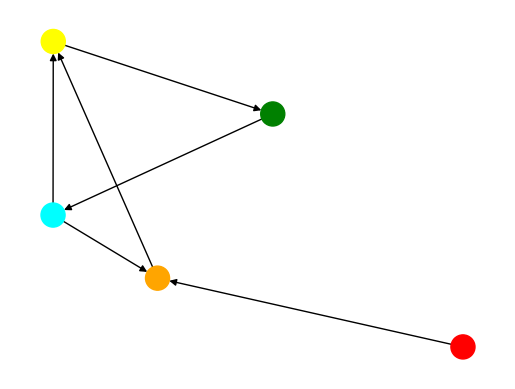

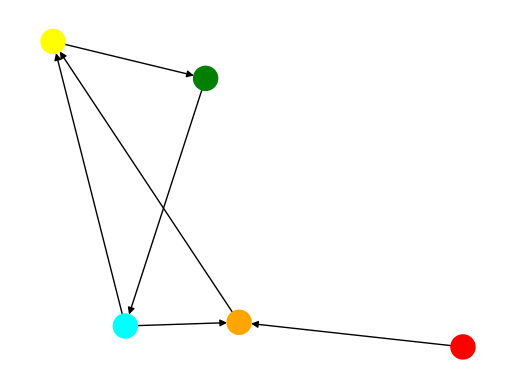

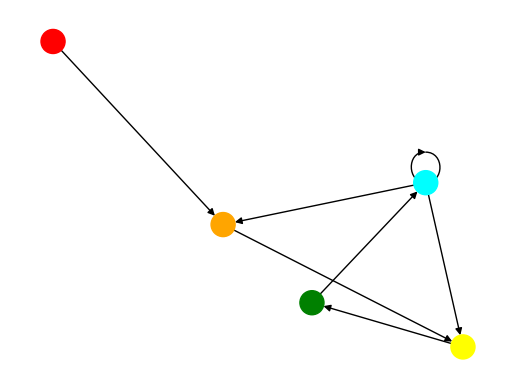

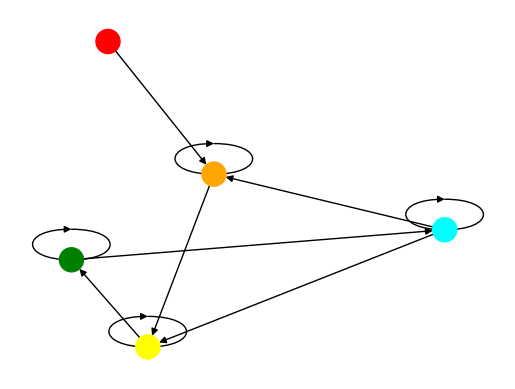

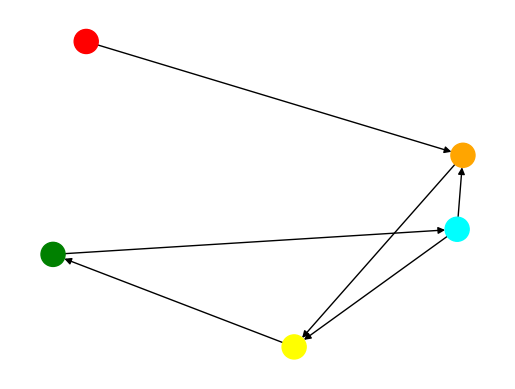

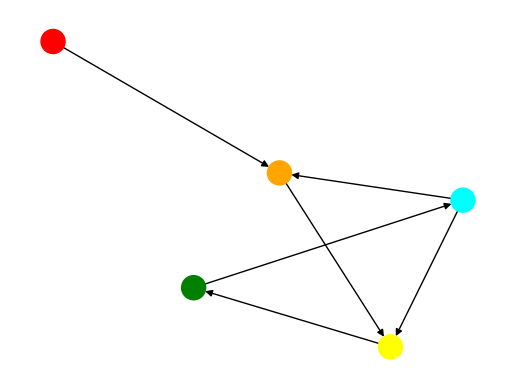

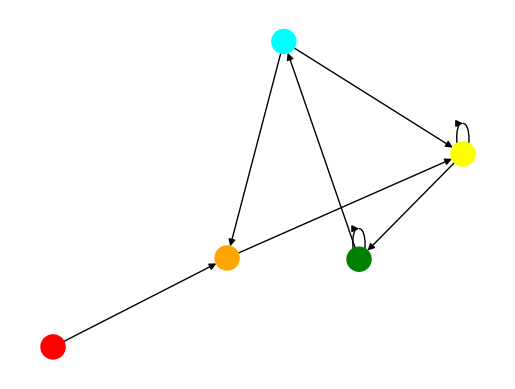

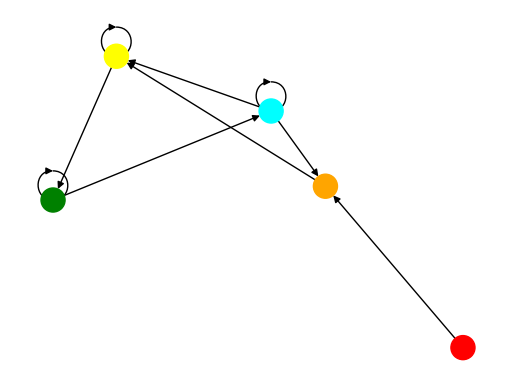

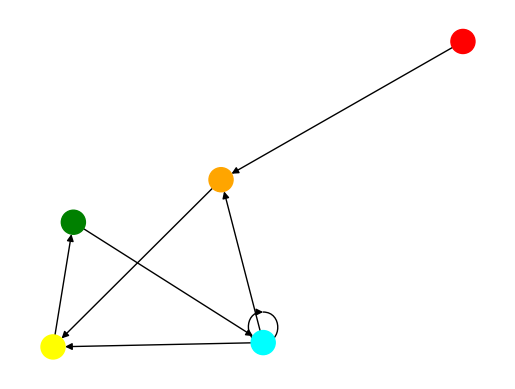

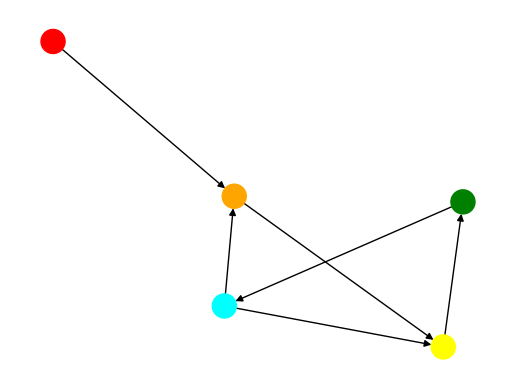

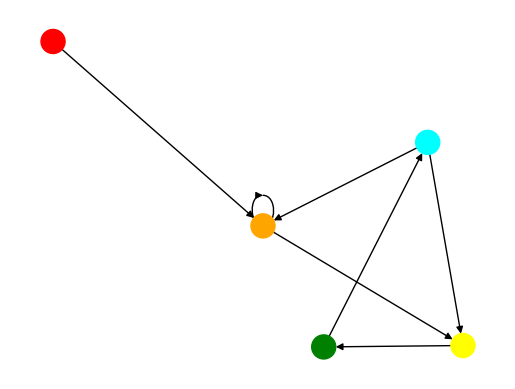

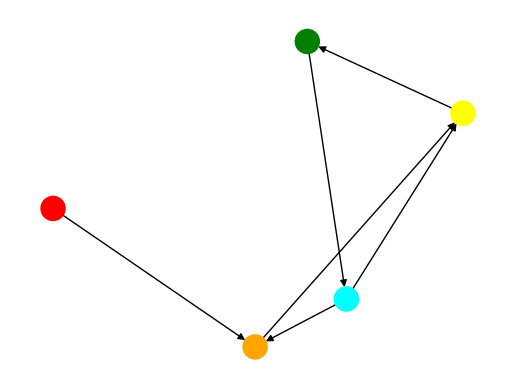

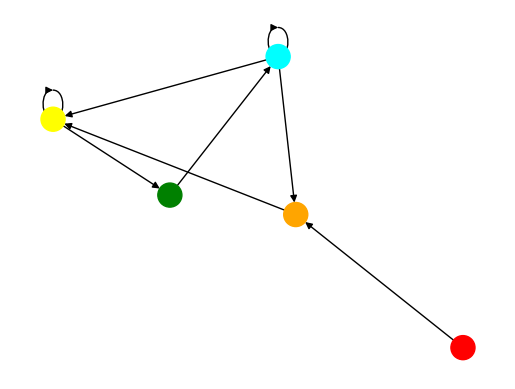

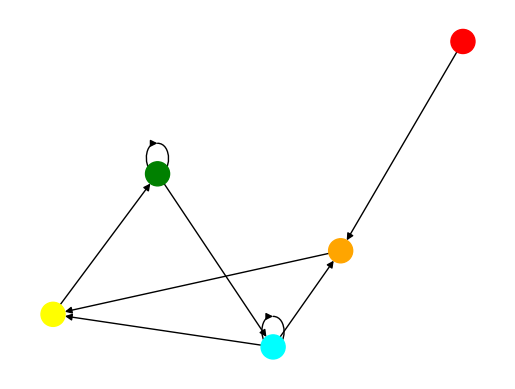

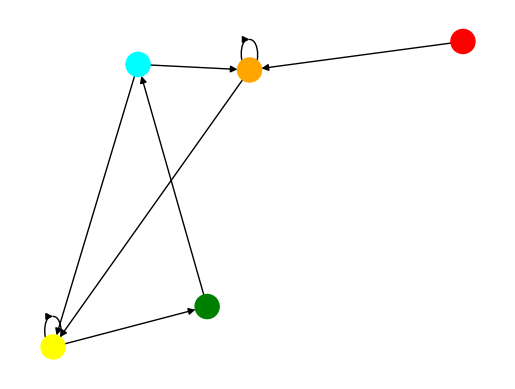

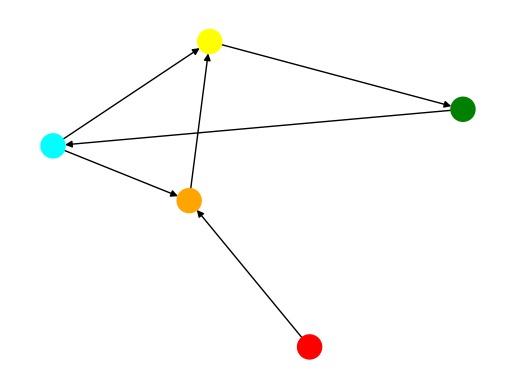

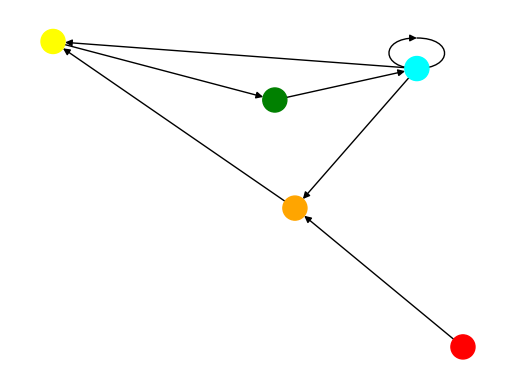

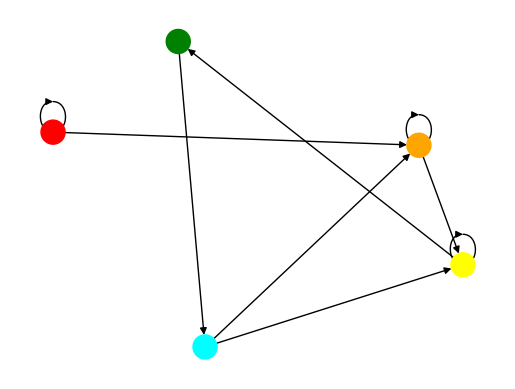

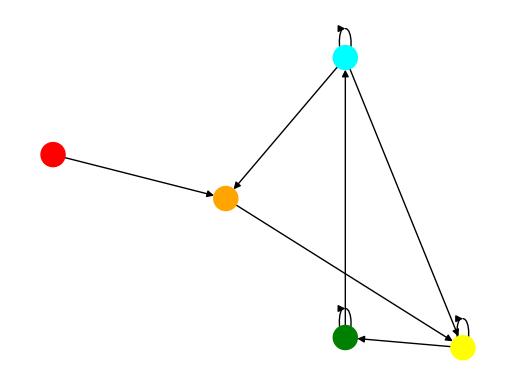

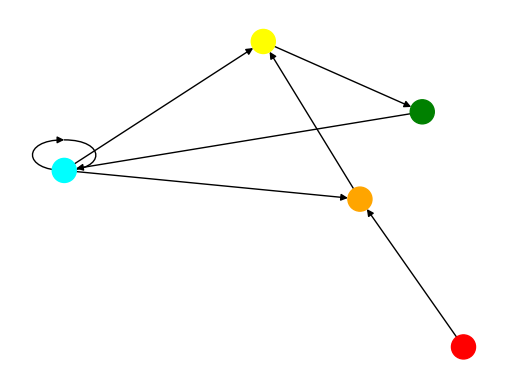

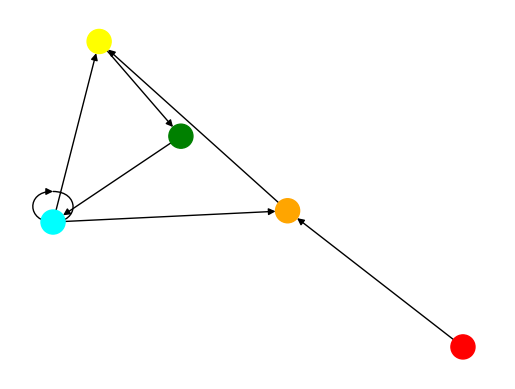

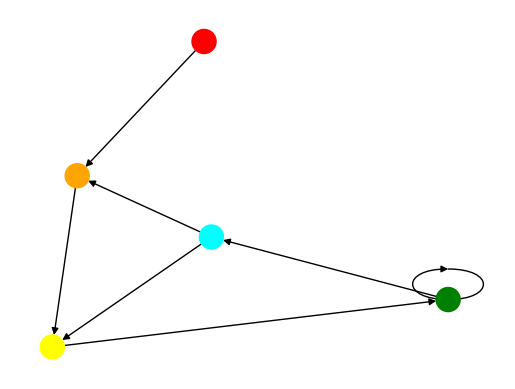

In [13]:
# Path to the logs
files = ["data3/logs_nome_vlad.json"]

# Color coding the different elements for the Sankey and Directed graphs
# color_dict = {'Other':'green', 'div.leaflet-pane leaflet-map-pane':'red'}
color_dict = {'Maryland Science Center and Planetarium':'red', 
              'USS Constellation':'orange', 'World Trade Center':'yellow', 
              'National Aquarium':'green', 'USCGC Taney':'cyan', 
              'Pratt Street Pavilion':'blue', 'Light Street Pavilion':'purple',
              'Chesapeake':'pink', 'Other':'black'}

# creating a list to store the generated directed graphs
graphs = {}

# Going through each log file indivudually
for file in files:
    data = setup(file, "datetime")
    for sessID,logs in data.items():
        # creating the directed graph and assigning the previously defined color-code
        (graph, colors) = get_color_graph(logs, color_dict, get_partition)
        f = plt.figure()
        # drawing the di-graph
        nx.draw(graph, pos=nx.spring_layout(graph), node_color=colors, ax=f.add_subplot(111))
        # adding the digraph to our previously defined 'graphs' list.
        graphs[sessID] = graph

In [20]:
print( (data['session_1688066755015']['session_16880667550152023-06-29 20:16:38.223000customvisit']['details']['name'] ) ) 

Maryland Science Center and Planetarium


Now we have all the graphs of temporally sorted logs indexed by their sessions. The next step is turning them into lists to be fed into the model:

First, we get the important information of every log in the session

In [14]:
sess_elements = {}
for sessID,logs in data.items():
    for logID,log in logs.items():
        elem_name = log['details']['name']
        if (not sessID in sess_elements.keys()):
            sess_elements[sessID] = [ elem_name ]
        else:
            sess_elements[sessID] += [ elem_name ]

In [15]:
print(sess_elements['session_1688066755015'])

['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney']


## Partitioning

In [38]:
import pandas as pd

#Our max "n" value for now will be 4, so n = [1,4]
data = [sess_elements[sessID] for sessID in sess_elements.keys() if len(sess_elements[sessID]) > 5]

print("Refined # of tasks/sessions: ", len(data))

# inputs = [s[:-1] for s in data]
# targets = [s[-1] for s in data]
n = 4
data_tups = [(s[:-n], s[-n:]) for s in data]
# print("data: ", data_tups)
df = pd.DataFrame(data_tups, columns=["inputs", "targets"])
df

Refined # of tasks/sessions:  22


,inputs,targets
0,"[Maryland Science Center and Planetarium, USS ...","[USCGC Taney, World Trade Center, National Aqu..."
1,"[Maryland Science Center and Planetarium, USS ...","[National Aquarium, USCGC Taney, World Trade C..."
2,"[Maryland Science Center and Planetarium, USS ...","[World Trade Center, National Aquarium, USCGC ..."
3,"[Maryland Science Center and Planetarium, USS ...","[USCGC Taney, World Trade Center, National Aqu..."
4,"[Maryland Science Center and Planetarium, USS ...","[USCGC Taney, World Trade Center, National Aqu..."
5,"[Maryland Science Center and Planetarium, USS ...","[USCGC Taney, World Trade Center, National Aqu..."
6,"[Maryland Science Center and Planetarium, USS ...","[World Trade Center, National Aquarium, Nation..."
7,"[Maryland Science Center and Planetarium, USS ...","[National Aquarium, National Aquarium, USCGC T..."
8,"[Maryland Science Center and Planetarium, USS ...","[USCGC Taney, World Trade Center, National Aqu..."
9,"[Maryland Science Center and Planetarium, USS ...","[USCGC Taney, World Trade Center, National Aqu..."


## **Model** (Training and Evaluation)

Our previous model:

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size)
#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, input_seq):
#         # Initialize hidden state and cell state
#         hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        
#         # Convert input sequence to tensor of indices
#         input_idx = [word2idx[w] for w in input_seq]
#         input_tensor = torch.tensor(input_idx, dtype=torch.long).unsqueeze(1)
        
#         # Embed input tensor
#         input_embedded = self.dropout(self.embedding(input_tensor))
        
#         # Pass through LSTM layer
#         lstm_out, hidden = self.lstm(input_embedded, hidden)
        
#         # Pass LSTM output through linear layer to get predicted next word
#         output = self.fc(lstm_out.view(len(input_seq), -1))
#         return output

# vocab = ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']
# # Define the vocabulary and index-to-word mapping
# word2idx = {w: i for i, w in enumerate(vocab)}
# idx2word = {i: w for i, w in enumerate(vocab)}

# # Define the model
# lstm = LSTM(input_size=len(vocab), hidden_size=8, output_size=len(vocab))
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(lstm.parameters())

# for epoch in range(1001):
#     for i,t in data_tups:
#         lstm.zero_grad()
#         hidden = (torch.zeros(1, 1, lstm.hidden_size), torch.zeros(1, 1, lstm.hidden_size))  # update hidden
#         output = lstm(i)
#         predicted_idx = output[-1].unsqueeze(0)
#         target_idx = torch.tensor([word2idx[t]], dtype=torch.long)
#         loss = loss_fn(predicted_idx, target_idx)
#         loss.backward()
#         optimizer.step()
    
#     if epoch % 100 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item()}")

**Working LSTM model:**

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_seq):
        # Initialize hidden state and cell state
        batch_size = 1  # Set the batch size to 1
        hidden = (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

        # Convert input sequence to tensor of indices
        input_idx = [word2idx[w] for w in input_seq]
        input_tensor = torch.tensor(input_idx, dtype=torch.long).unsqueeze(1)

        # Embed input tensor
        input_embedded = self.dropout(self.embedding(input_tensor))

        # Pass through LSTM layer
        lstm_out, hidden = self.lstm(input_embedded, hidden)

        # Pass LSTM output through linear layer to get predicted next words
        output = self.fc(lstm_out.view(len(input_seq), batch_size, -1))
        return output

vocab = ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']
# Define the vocabulary and index-to-word mapping
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}

# Define the model
lstm = LSTM(input_size=len(vocab), hidden_size=len(vocab), output_size=len(vocab))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())

for epoch in range(1001):
    for i, t in data_tups:
        lstm.zero_grad()
        hidden = (torch.zeros(1, len(i), lstm.hidden_size), torch.zeros(1, len(i), lstm.hidden_size))
        output = lstm(i)
        predicted = output.view(-1, len(vocab))
        target = torch.tensor([word2idx[w] for w in t], dtype=torch.long)
        loss = -torch.log_softmax(predicted, dim=1)[range(len(target)), target].mean()
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 2.1430904865264893
Epoch 100, Loss: 0.3328467011451721
Epoch 200, Loss: 0.2368176132440567
Epoch 300, Loss: 0.21209341287612915
Epoch 400, Loss: 0.23820795118808746
Epoch 500, Loss: 0.21271227300167084
Epoch 600, Loss: 0.24538832902908325
Epoch 700, Loss: 0.22321133315563202
Epoch 800, Loss: 0.23853154480457306
Epoch 900, Loss: 0.24548634886741638
Epoch 1000, Loss: 0.22009938955307007


Attempting the same as before, but **now with k-fold validation to get the best trained model:**

In [47]:
import random
import sys

# Shuffle data tuples
random.shuffle(data_tups)

# Define the number of folds
k = 5

# Divide data tuples into k subsets of equal size
subset_size = len(data_tups) // k
data_subsets = [data_tups[i:i+subset_size] for i in range(0, len(data_tups), subset_size)]

best_loss = float(sys.maxsize)
best_lstm = None
best_val_fold = []
best_train_fold = []
# Train and validate model on each subset
for fold in range(k):
    # Define the model
    lstm = LSTM(input_size=len(vocab), hidden_size=len(vocab), output_size=len(vocab))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters())

    # Get the training and validation data for this fold
    val_data = data_subsets[fold]
    train_data = [tup for i, subset in enumerate(data_subsets) for tup in subset if i != fold]

    # Train the model on the training data
    for epoch in range(1001):
        for i, t in train_data:
            lstm.zero_grad()
            hidden = (torch.zeros(1, len(i), lstm.hidden_size), torch.zeros(1, len(i), lstm.hidden_size))
            output = lstm(i)
            predicted = output.view(-1, len(vocab))
            target = torch.tensor([word2idx[w] for w in t], dtype=torch.long)
            loss = -torch.log_softmax(predicted, dim=1)[range(len(target)), target].mean()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            print(f"Fold {fold+1}, Epoch {epoch}, Training Loss: {loss.item()}")

    # Evaluate the model on the validation data
    val_loss = 0
    with torch.no_grad():
        for i, t in val_data:
            hidden = (torch.zeros(1, len(i), lstm.hidden_size), torch.zeros(1, len(i), lstm.hidden_size))
            output = lstm(i)
            predicted = output.view(-1, len(vocab))
            target = torch.tensor([word2idx[w] for w in t], dtype=torch.long)
            loss = -torch.log_softmax(predicted, dim=1)[range(len(target)), target].mean()
            val_loss += loss.item()
    
    val_loss /= len(val_data)
    if val_loss < best_loss:
        best_loss = val_loss
        best_lstm = lstm
        best_val_fold = val_data
        best_train_fold = train_data
    
    print(f"Fold {fold+1}, Validation Loss: {val_loss}")
    print()

torch.save(best_lstm, 'model_3.pth')


Fold 1, Epoch 0, Training Loss: 2.067033290863037
Fold 1, Epoch 100, Training Loss: 1.1193742752075195
Fold 1, Epoch 200, Training Loss: 1.132355809211731
Fold 1, Epoch 300, Training Loss: 1.2618696689605713
Fold 1, Epoch 400, Training Loss: 1.071441411972046
Fold 1, Epoch 500, Training Loss: 1.123008370399475
Fold 1, Epoch 600, Training Loss: 1.1547011137008667
Fold 1, Epoch 700, Training Loss: 1.1106982231140137
Fold 1, Epoch 800, Training Loss: 1.1778168678283691
Fold 1, Epoch 900, Training Loss: 1.0926169157028198
Fold 1, Epoch 1000, Training Loss: 1.1412861347198486
Fold 1, Validation Loss: 1.4721315018832684

Fold 2, Epoch 0, Training Loss: 2.148730754852295
Fold 2, Epoch 100, Training Loss: 1.1562241315841675
Fold 2, Epoch 200, Training Loss: 1.2329132556915283
Fold 2, Epoch 300, Training Loss: 1.1691943407058716
Fold 2, Epoch 400, Training Loss: 1.2868311405181885
Fold 2, Epoch 500, Training Loss: 1.215517282485962
Fold 2, Epoch 600, Training Loss: 1.34470534324646
Fold 2, Epoc

## Model Performance

In [48]:
import torch

best_lstm = torch.load('model_3.pth')

print("Size of the validation set for our confusion matrix: ", len(best_val_fold))

Size of the validation set for our confusion matrix:  4


In the following confusion matrix, we are displaying where the validation set's true labels intersect/diverge from the model's predictions. More shaded boxes and values **on the diagonal** means the model is making the **correct predictions**. More shaded boxes and values **anywhere else** means the **model is confused** with some of the validation set's inputs on what the right prediction should be.

In [60]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Set the model to evaluation mode
best_lstm.eval()

# Create variables to store predictions and ground truth labels
predictions = []
labels = []

# Loop through the test dataset and make predictions
for i, t in best_val_fold:
    output = best_lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_label = idx2word[predicted_idx]
    label = t
    predictions.append(predicted_label)
    labels.append(label)

# Convert labels and predictions to their corresponding strings
labels_str = [' '.join(label) for label in labels]
predictions_str = [' '.join(pred) for pred in predictions]

# Create a dictionary to map strings to indices
label2idx = {label_str: idx for idx, label_str in enumerate(vocab)}

# Convert labels and predictions to their corresponding indices
label_indices = [label2idx[label_str] for label_str in labels_str]
prediction_indices = [label2idx[pred_str] for pred_str in predictions_str]

# Create the confusion matrix
conf_mat = confusion_matrix(label_indices, prediction_indices)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(conf_mat, cmap='Blues')

# Set ticks for x and y axis
ax.set_xticks(np.arange(len(vocab)))
ax.set_yticks(np.arange(len(vocab)))

# Set labels for x and y axis
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(vocab)
ax.set_yticklabels(vocab)

# Loop over the data and create annotations for each cell
for i in range(len(vocab)):
    for j in range(len(vocab)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="w")

# Set title and colorbar
ax.set_title("Confusion Matrix")
fig.colorbar(im)
plt.show()

KeyError: 'World Trade Center National Aquarium National Aquarium USCGC Taney'

Some specific expected model targets for their respective inputs:

In [66]:
# Test the model on a new input sequence
# inputs = df['inputs'].tolist() # A list of inputs. Example: [['United States', 'Japan', 'Australia'], ['Canada', 'United States', 'Mexico', 'Brazil'],  ['Canada', 'United States', 'United Kingdom', 'France', 'Germany', 'Poland'], ['Russia', 'China', 'India', 'Brazil'], and so on...]
# targets = df['targets'].tolist() # A list of targets for each input. Example: ['India', 'Argentina', 'Turkey', 'South Africa', and so on...]

input_seqs = [['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium']]
for i in input_seqs:
    output = best_lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_label = idx2word[predicted_idx] # This is just one word, we need the sequence
    print(f'Input sequence: {i}, Predicted next sequence: {predicted_label}')
# Should be USCGC Taney

Input sequence: ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium'], Predicted next sequence: USCGC Taney


So the expected targets are hit when the model is given the right inputs. But what about other inputs?

In [67]:
input_seqs = [['Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], ['USCGC Taney', 'Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], ['USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']]
for i in input_seqs:
    output = best_lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_word = idx2word[predicted_idx]
    print(f'Input sequence: {i}, Predicted next word: {predicted_word}')
#Should expect: USCGC Taney for all of them, because that's the only output there can be right now

Input sequence: ['Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], Predicted next word: USCGC Taney
Input sequence: ['USCGC Taney', 'Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], Predicted next word: USCGC Taney
Input sequence: ['USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], Predicted next word: USCGC Taney
Input sequence: ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], Predicted next word: National Aquarium


As we can see, there's still work to do. We will see if we can fix this with more data or another model.